In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import glob
import shutil
import matplotlib.pyplot as plt

In [4]:
inp_base_dir = 'C:/Users/Dell/jupyter_project/archive (1)/Data'
dirnames = ['LR', 'HR']
out_base_dir = './'

In [5]:
for dirname in dirnames:
  img_path = os.path.join(inp_base_dir, dirname)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(dirname, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(out_base_dir, 'train', dirname)):
      os.makedirs(os.path.join(out_base_dir, 'train', dirname))
    shutil.copy(t, os.path.join(out_base_dir, 'train', dirname))

  for v in val:
    if not os.path.exists(os.path.join(out_base_dir, 'val', dirname)):
      os.makedirs(os.path.join(out_base_dir, 'val', dirname))
    shutil.copy(v, os.path.join(out_base_dir, 'val', dirname))

LR: 100 Images
HR: 100 Images


In [4]:
train_dir = os.path.join(out_base_dir,'train')
val_dir  = os.path.join(out_base_dir, 'val')

In [5]:
import tensorflow as tf
IMG_SHAPE = 256
LATENT_DIM = 64
NUM_CHANNELS = 3

In [6]:
def process_and_scale_train(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_jpeg(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(train_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_jpeg(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [7]:
def process_and_scale_val(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_jpeg(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(val_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_jpeg(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [8]:
train_ds_lr_files = tf.data.Dataset.list_files(train_dir + "/LR/*", shuffle = False)
val_ds_lr_files = tf.data.Dataset.list_files(val_dir + "/LR/*", shuffle = False)

In [9]:
train_dataset_lr = train_ds_lr_files.shuffle(len(train_ds_lr_files)).map(process_and_scale_train).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset_lr = val_ds_lr_files.map(process_and_scale_val).batch(8).prefetch(tf.data.AUTOTUNE)

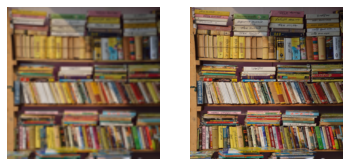

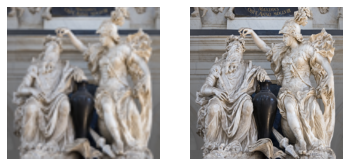

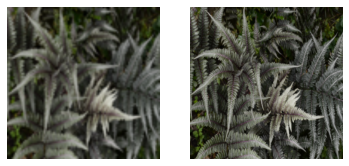

In [10]:
for train_lr, train_hr in train_dataset_lr.take(3):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(train_lr[0].numpy())
    ax[0].axis("off")
    ax[1].imshow(train_hr[0].numpy())
    ax[1].axis("off")

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Conv2DTranspose, Lambda, Reshape, Flatten

In [12]:
input_img = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)) #(accepts only 256, 256, 3)

l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l7)
l9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l11)
l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

autoencoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)

autoencoder.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01), #optimizer='adam', #optimizer='adadelta',
                    loss='mean_absolute_error', 
                    metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse')])

In [13]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## **Model Training**

In [14]:
history = autoencoder.fit(train_dataset_lr,
                          validation_data = val_dataset_lr,
                          epochs = 200) #100 + 50 + 100: learning_rate = 0.001, optimizer = adadelta
                                        #100 + 100: learning_rate = 0.01, optimizer = adadelta

Epoch 1/200
10/10 [==============================] - 11s 285ms/step - loss: 0.1842 - rmse: 0.2484 - val_loss: 0.1118 - val_rmse: 0.1567
Epoch 2/200
10/10 [==============================] - 2s 178ms/step - loss: 0.1270 - rmse: 0.1708 - val_loss: 0.0971 - val_rmse: 0.1398
Epoch 3/200
10/10 [==============================] - 2s 186ms/step - loss: 0.1167 - rmse: 0.1603 - val_loss: 0.0920 - val_rmse: 0.1341
Epoch 4/200
10/10 [==============================] - 2s 193ms/step - loss: 0.1081 - rmse: 0.1498 - val_loss: 0.0873 - val_rmse: 0.1286
Epoch 5/200
10/10 [==============================] - 2s 180ms/step - loss: 0.0994 - rmse: 0.1387 - val_loss: 0.0840 - val_rmse: 0.1244
Epoch 6/200
10/10 [==============================] - 2s 180ms/step - loss: 0.0992 - rmse: 0.1405 - val_loss: 0.0817 - val_rmse: 0.1212
Epoch 7/200
10/10 [==============================] - 2s 179ms/step - loss: 0.0914 - rmse: 0.1296 - val_loss: 0.0790 - val_rmse: 0.1181
Epoch 8/200
10/10 [==============================] - 2

In [15]:
def plot_model(model_name_history):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot rmse per iteration
    ax[1].plot(model_name_history.history['rmse'], label='rmse')
    ax[1].plot(model_name_history.history['val_rmse'], label='val_rmse')
    ax[1].legend()

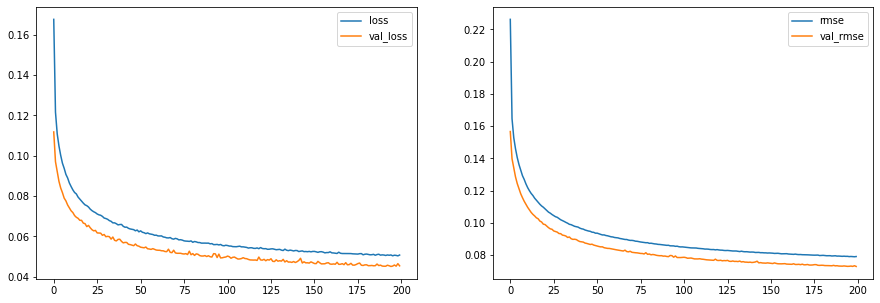

In [16]:
plot_model(history)

In [17]:
pred = autoencoder.predict(val_dataset_lr.take(1))

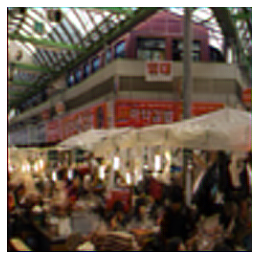

In [18]:
plt.figure(figsize = (4.5,4.5))
plt.imshow(pred[7])
plt.axis("off")
plt.show()

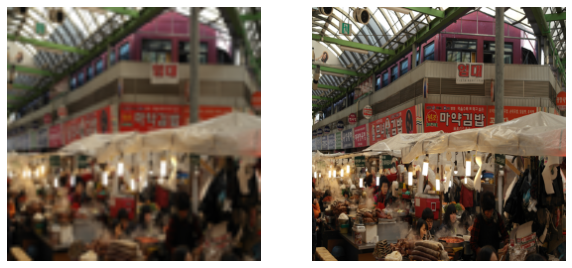

In [19]:
for img_input, img_output in val_dataset_lr.take(1):
    fig, ax = plt.subplots(1,2, figsize = (10,10))
    ax[0].imshow(img_input.numpy()[7])
    ax[0].axis("off")
    ax[1].imshow(img_output.numpy()[7])
    ax[1].axis("off")